**First order statistical mixing**

In [78]:
from utils.image_treatment import preprocess_image
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from wasserstein.texture_mixing import compute_steerable_pyramid_coeffs
from wasserstein.basic_wasserstein import compute_sliced_wass_barycenter
import pyrtools as pt
from tqdm import tqdm 


In [2]:
image_path1 = 'data/elephant.jpg'
image_path2 = 'data/gateau.png'

### Exemples pour le calcul des coeffs the steerable pyramid transform

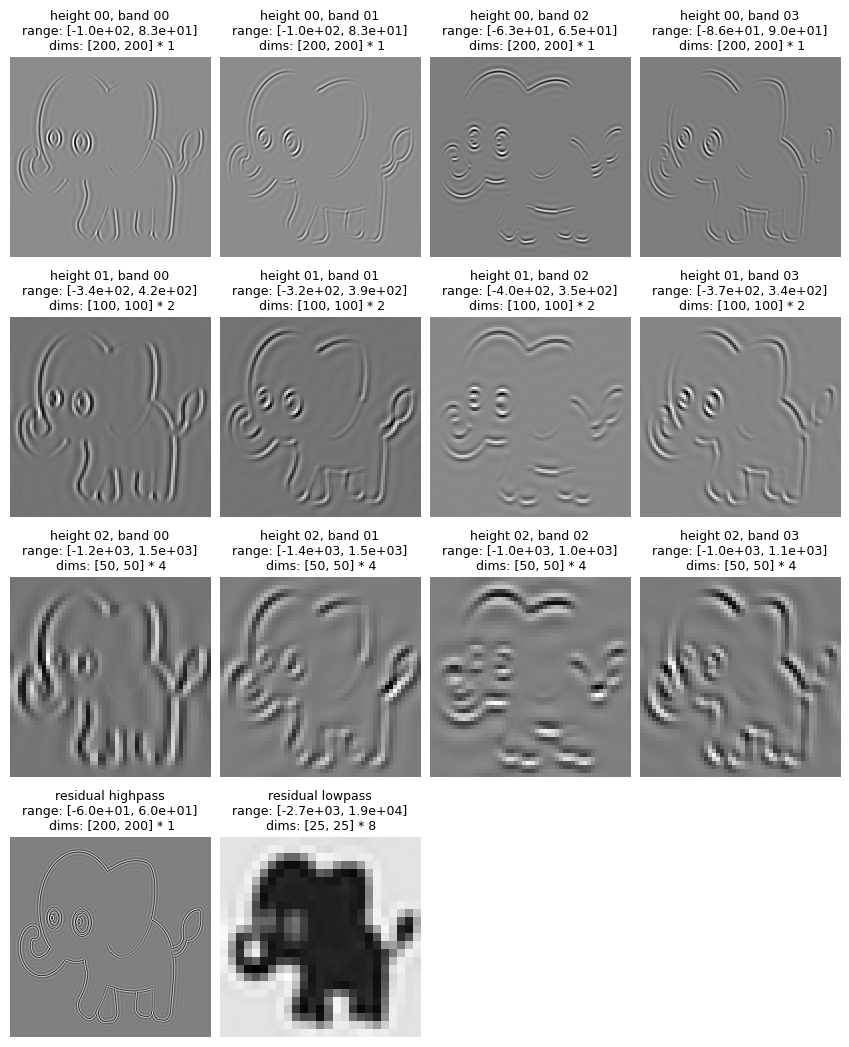

In [3]:
# Example of computing the coefficients with Steerable Pyramid Transform 

# ouvrir l'image en niveaux de gris
image1 = Image.open(image_path1).convert("L")
image1 = np.array(image1.resize((200, 200)))

# calcul  des coeffs 
pyr = pt.pyramids.SteerablePyramidFreq(image1, height=3, order=3)
pt.pyrshow(pyr.pyr_coeffs);

Statistiques des coefficients pour le canal Rouge:
residual_highpass: mean=6.7700511863222344e-15, std=12.221261799169344
(0, 0): mean=8.526512829121201e-18, std=4.265324767373329
(0, 1): mean=-4.263256414560601e-18, std=9.096566162820416
(0, 2): mean=7.105427357601002e-18, std=11.869218041236806
(0, 3): mean=2.1316282072803004e-18, std=5.161376984338224
(1, 0): mean=2.8563817977556027e-16, std=17.27897717965027
(1, 1): mean=4.5474735088646414e-17, std=30.155990878241358
(1, 2): mean=-1.3642420526593922e-16, std=39.32673906481603
(1, 3): mean=9.094947017729283e-17, std=18.812741632328972
(2, 0): mean=1.77351466845721e-15, std=75.48851949666455
(2, 1): mean=1.9554136088117957e-15, std=83.31748327503308
(2, 2): mean=1.8189894035458566e-16, std=109.44562143083016
(2, 3): mean=-9.094947017729283e-16, std=62.000599595066376
residual_lowpass: mean=7111.944, std=2169.701643718805

Statistiques des coefficients pour le canal Vert:
residual_highpass: mean=5.354650056688115e-15, std=11.679011630

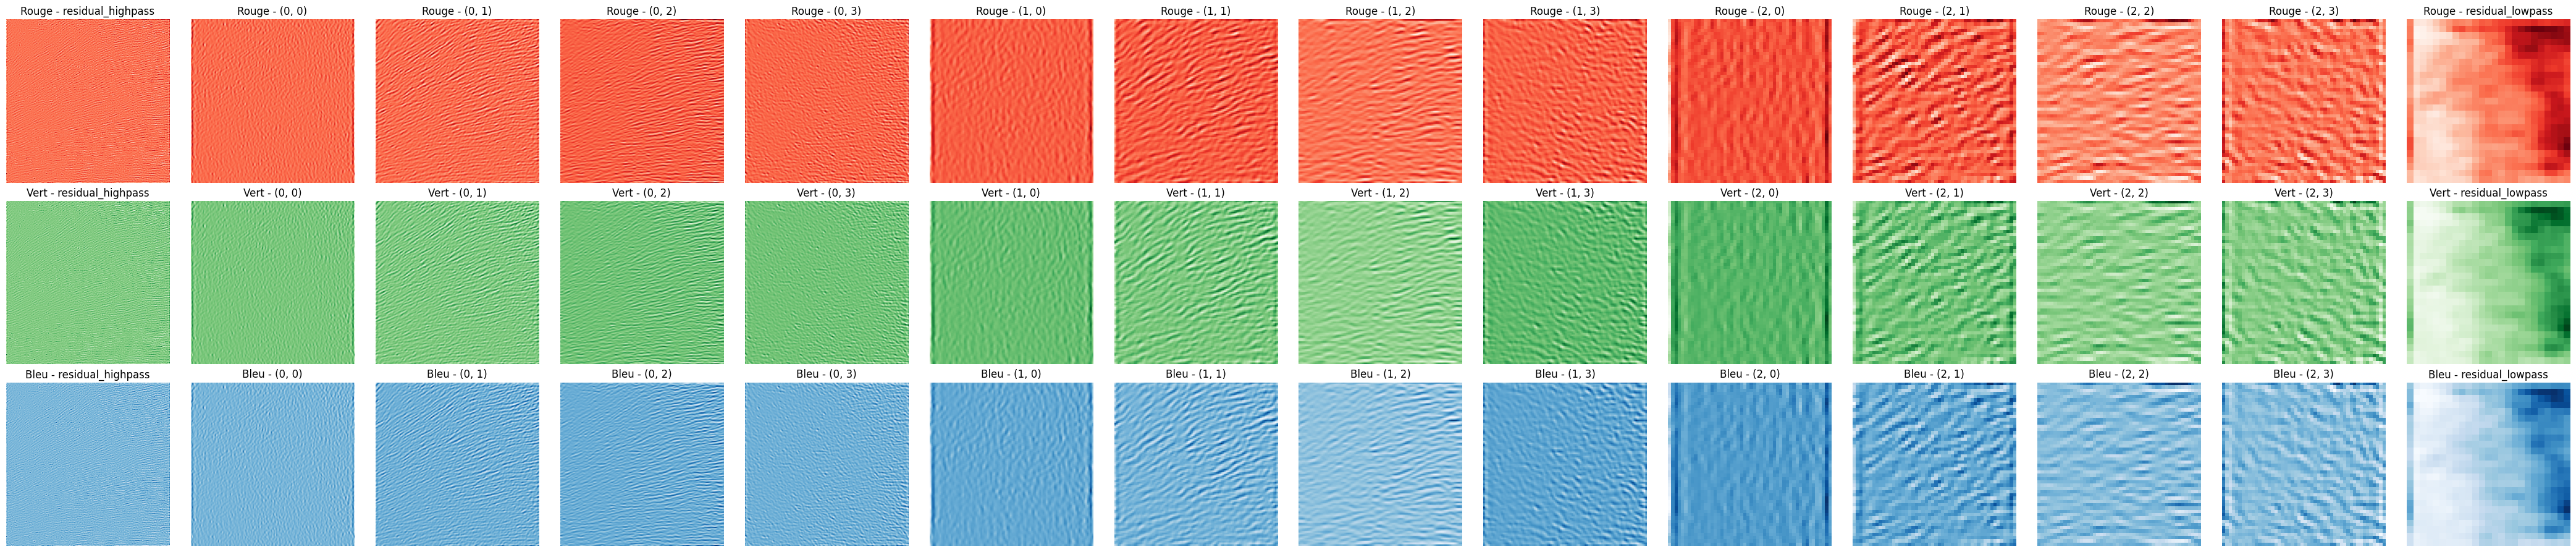

In [4]:
# calcul des coeffs sur les 3 canaux pour un exemple donné
texture_path1 = 'data/Fur.jpg'
image = Image.open(texture_path1).resize((200, 200))

# séparation les canaux R, G, B
image_r, image_g, image_b = image.split()
image_r = np.array(image_r)
image_g = np.array(image_g)
image_b = np.array(image_b)

# calcul des coeffs
pyr_r = pt.pyramids.SteerablePyramidFreq(image_r, height=3, order=3)
pyr_g = pt.pyramids.SteerablePyramidFreq(image_g, height=3, order=3)
pyr_b = pt.pyramids.SteerablePyramidFreq(image_b, height=3, order=3)

# statistiques pour chaque canal (pour montrer qu'ils sont différents)
print("Statistiques des coefficients pour le canal Rouge:")
for band in pyr_r.pyr_coeffs:
    print(f"{band}: mean={pyr_r.pyr_coeffs[band].mean()}, std={pyr_r.pyr_coeffs[band].std()}")

print("\nStatistiques des coefficients pour le canal Vert:")
for band in pyr_g.pyr_coeffs:
    print(f"{band}: mean={pyr_g.pyr_coeffs[band].mean()}, std={pyr_g.pyr_coeffs[band].std()}")

print("\nStatistiques des coefficients pour le canal Bleu:")
for band in pyr_b.pyr_coeffs:
    print(f"{band}: mean={pyr_b.pyr_coeffs[band].mean()}, std={pyr_b.pyr_coeffs[band].std()}")

band_keys = list(pyr_r.pyr_coeffs.keys())

# plots 
fig, axes = plt.subplots(3, len(band_keys), figsize=(3 * len(band_keys), 9))  # 3 lignes pour R, G, B ; colonnes = nombre de bandes

# afficher chaque sous-bande pour chaque canal
for i, band in enumerate(band_keys):
    axes[0, i].imshow(pyr_r.pyr_coeffs[band], cmap='Reds')
    axes[0, i].set_title(f"Rouge - {band}")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(pyr_g.pyr_coeffs[band], cmap='Greens')
    axes[1, i].set_title(f"Vert - {band}")
    axes[1, i].axis('off')
    
    axes[2, i].imshow(pyr_b.pyr_coeffs[band], cmap='Blues')
    axes[2, i].set_title(f"Bleu - {band}")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

# Retour 

In [5]:
image1 = np.array(preprocess_image(image_path1, new_size = (200, 200)))
image2 = np.array(preprocess_image(image_path2, new_size = (70, 70)))

In [6]:
def compute_steerable_pyramid_coeffs(image, num_scales=3, num_orientations=4):
    """
    Compute steerable pyramid coefficients with specified orientations using pyrtools.
    
    Parameters:
    - image: 2D numpy array, input grayscale image.
    - num_scales: int, number of scales.
    - num_orientations: int, number of orientations.

    Returns:
    - coeffs: Dictionary of coefficients organized by scale and orientation.
    """
    # Initialize the steerable pyramid
    pyramid = pt.pyramids.SteerablePyramidFreq(image, height=num_scales, order=num_orientations-1)

    return pyramid.pyr_coeffs

In [7]:
def compute_3D_wavelets_coeffs(image, num_scales=4, num_orientations=4):
    """
    Compute wavelets coefficients (highpass, bandpass, low-residuals) for the 3 channels (R,G,B) of an image
    
    Parameters:
    - image: 2D numpy array, input grayscale image.
    - num_scales: int, number of scales.
    - num_orientations: int, number of orientations.

    Returns:
    - wavelets_coeffs: Dictionary of coefficients organized by channel (R,G,B) and then by bandpass (highpass, bandpass -scale and orientation- and low residual).
    """
    wavelets_coeffs = {}
    rgb = ['R','G','B']
    for channel in range(3):
        wavelets_coeffs[rgb[channel]] = compute_steerable_pyramid_coeffs(image[:, :, channel], num_scales=num_scales, num_orientations=num_orientations)
    return(wavelets_coeffs)

In [62]:
def compute_wavelet_coeffs_barycenter(textures, num_scales=4, num_orientations=4):
    """
    Compute the barycenter of wavelets coefficients --> Y^l (see page 9 in paper)
    
    Parameters:
    - textures: 3D numpy array, input RGB image.
    - num_scales: int, number of scales.
    - num_orientations: int, number of orientations.

    Returns:
    - bar_wavelet_coeffs_RGB: Dictionary of barycenters of wavelets coefficients by channel (R,G,B) and then by highpass/bandpass/lowresidual
    """

    bar_wavelet_coeffs = {}
    bar_wavelet_coeffs_RGB = {}
    RGB = ['R','G','B']
    wavelets_coeffs = [compute_3D_wavelets_coeffs(image) for image in textures]

    for rgb in RGB:
        for k in wavelets_coeffs[0][rgb].keys():
                distributions = [w[rgb][k].reshape(-1,1) for w in wavelets_coeffs] #reshape --> flattens the image to compute the barycenter
                n = int(np.sqrt(distributions[0].shape[0]))
                bar_wavelet_coeffs[k] = (compute_sliced_wass_barycenter(distributions, rho = None)).reshape(n, n)
        bar_wavelet_coeffs_RGB[rgb] = bar_wavelet_coeffs
    return(bar_wavelet_coeffs_RGB)

In [63]:
textures = [image1, image2]
bar_wavelet_coeffs_RGB = compute_wavelet_coeffs_barycenter(textures, num_scales=4, num_orientations=4)

2


KeyboardInterrupt: 

In [ ]:
bar_wavelet_coeffs_RGB
#il ne manque plus que le barycentre "classique" i.e. sur les pixels
#next step --> la projection (13) du papier

### Barycentre classique 

In [23]:
texture_path1 = 'data/Fur.jpg'
texture_path2 = 'data/Red.jpg'

texture1 = np.array(preprocess_image(texture_path1, new_size = (200, 200)))
texture2 = np.array(preprocess_image(texture_path2, new_size = (200, 200)))

array([[[108,  94,  87],
        [ 67,  56,  51],
        [ 61,  54,  48],
        ...,
        [187, 144, 135],
        [216, 178, 166],
        [210, 183, 168]],

       [[ 50,  40,  34],
        [ 64,  55,  48],
        [ 62,  53,  45],
        ...,
        [176, 134, 121],
        [175, 132, 118],
        [204, 159, 145]],

       [[ 63,  59,  52],
        [ 47,  41,  31],
        [ 74,  66,  56],
        ...,
        [182, 148, 132],
        [176, 139, 123],
        [189, 155, 139]],

       ...,

       [[ 94,  75,  68],
        [104,  85,  77],
        [ 93,  74,  66],
        ...,
        [196, 180, 159],
        [177, 158, 139],
        [184, 161, 142]],

       [[ 54,  42,  31],
        [ 64,  49,  40],
        [ 76,  61,  53],
        ...,
        [181, 160, 134],
        [164, 141, 112],
        [203, 179, 144]],

       [[ 96,  76,  61],
        [104,  83,  72],
        [ 84,  68,  60],
        ...,
        [ 95,  81,  63],
        [ 73,  54,  36],
        [ 97,  70,  46]]

In [93]:
def compute_sliced_wass_barycenter_pixels(textures, weights=None):
    # Initialisation de la texture barycentre
    barycenter = {}
    
    # Noms des canaux RGB
    RGB = ['R', 'G', 'B']
    
    for i, rgb in tqdm(enumerate(RGB)):
        # Extraire le canal correspondant et le reshaper pour avoir un vecteur colonne
        channel_textures = [
            textures[0][:, :, i].astype(np.float64).reshape(-1, 1),  
            textures[1][:, :, i].astype(np.float64).reshape(-1, 1)  
        ]
        print(f'Length of channel {rgb}: {len(channel_textures[0])}')

        # Calculer le barycentre
        n = int(np.sqrt(channel_textures[0].shape[0]))
        barycenter_result = compute_sliced_wass_barycenter(channel_textures, rho=weights).reshape(n, n)
        barycenter[rgb] = barycenter_result
    
    return barycenter



textures = [texture1, texture2]
results = compute_sliced_wass_barycenter_pixels(textures, weights=None)


0it [00:00, ?it/s]

Length of channel R: 40000


1it [00:56, 56.39s/it]

Length of channel G: 40000


2it [01:45, 52.17s/it]

Length of channel B: 40000


3it [02:36, 52.19s/it]


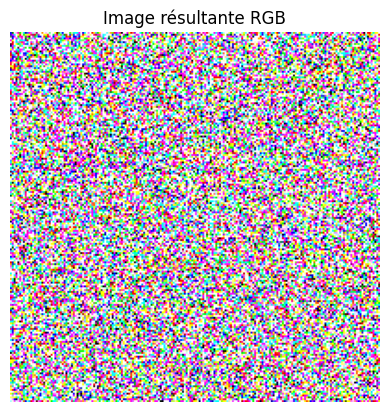

In [74]:
# affichage de la figure avec les 
height, width = results['R'].shape

image_color = np.zeros((height, width, 3))  
image_color[..., 0] = np.clip(results['R'], 0, 1)  
image_color[..., 1] = np.clip(results['G'], 0, 1) 
image_color[..., 2] = np.clip(results['B'], 0, 1)

plt.imshow(image_color)
plt.title('Image résultante RGB')
plt.axis('off')  
plt.show()

## Projection